# Topic : Lecture 16 Transfer Learning

Follow the CRSIP-DM method
1. Step 1: Import library, import data
2. Step 2: Pre-processing (missing data, categorical type, normalization, format transform, data augmentation)
3. Step 3: Build ML Model
4. Step 4: Evaluate Model
5. Step 5: Deploy (Prediction)


## Step 1:  Load data (also import library)

In [13]:
!pip install torch torchvision
!pip install Pillow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# import library
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# get data  (homework 4 要找一個github, 裡面有dataset的folder)
#!git clone https://github.com/jaddoescad/ants_and_bees.git
#!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git
!git clone https://github.com/laxmimerit/dog-cat-full-dataset.git
#!rm -rf ./Face-Mask-Detection/
# !rm -rf ./ants_and_bees/
#!rm -rf ./dog-cat-full-dataset/

fatal: destination path 'dog-cat-full-dataset' already exists and is not an empty directory.


In [16]:
!ls ./dog-cat-full-dataset/data/train

cats  dogs


# Step 2: Pre-process X, Y
* format transform (轉換成numpy format)
* missing data (imputation)差補
* category data transform 
* data augmentation
* normalization


In [17]:
transform_train = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
          transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ])


transform = transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_dataset = datasets.ImageFolder('dog-cat-full-dataset/data/train', transform=transform)
validation_dataset = datasets.ImageFolder('dog-cat-full-dataset/data/train', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)


In [18]:
print(len(training_dataset))
print(len(validation_dataset))

20000
20000


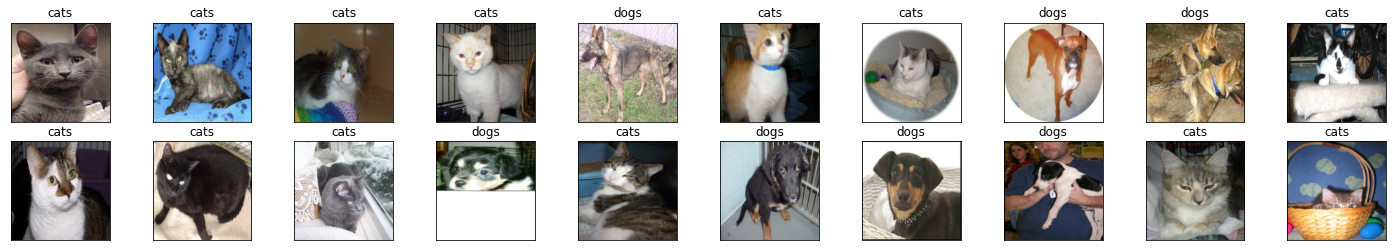

In [19]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

# !ls ./Face-Mask-Detection/dataset/

classes=('cats','dogs')

dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

# Step 3: Build Model for training

<img src="https://ithelp.ithome.com.tw/upload/images/20171206/20001976yeCo1PvEOs.jpg" width=500 />

In [20]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# turn off gradient for all parameters in features extraction 
for param in model.features.parameters():
  param.requires_grad = False

# modify last node from 1000 to 2 
# import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

print("output features=",model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Step 4 Training Model

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [23]:
epochs = 2
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.0036, acc 0.9742 
validation loss: 0.0011, validation acc 0.9936 
epoch : 2
training loss: 0.0016, acc 0.9886 
validation loss: 0.0005, validation acc 0.9966 


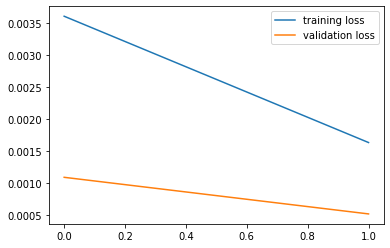

In [24]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## Step 5 Testing


### cats
<img src="https://previews.123rf.com/images/feedough/feedough1201/feedough120100013/11890967-head-of-a-cute-big-english-cat-on-white-background.jpg" alt="mask" width="300"/>

### dogs
<img src="https://live-production.wcms.abc-cdn.net.au/ff1221fbfdb2fe163fdda15df5f77676?impolicy=wcms_crop_resize&cropH=394&cropW=700&xPos=0&yPos=37&width=862&height=485" alt="no mask" width="300"/>



In [25]:
!pip3 install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 11.8 MB/s 
     |████████████████████████████████| 112 kB 64.3 MB/s 
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007272 sha256=76c8e216eaf907c71eb638fa80f79297932a4f9d0aed766a80e56618a5065d06
  Stored in directory: /root/.cache/pip/wheels/ec/1e/24/dbc5e4964ea99cad93230a9013d934fb5adc322c3102f69e45
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35432 sha256=904b270667a27ca9db2b4aadd7edb8fa05513a5be032d16bd00809a7a77b4121
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into acco

In [26]:
import PIL.ImageOps

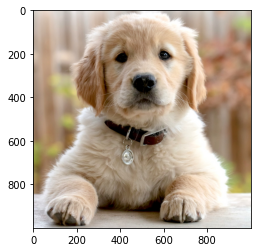

In [27]:
import requests
from PIL import Image

# url = 'http://media.rojaklah.com/wp-content/uploads/2017/09/19150232/1909bigstar1.jpg'
# url ='https://images.twgreatdaily.com/images/image/7fe/7feccfb21a05e5bd97bf2dab8e953cf7.jpg'
url='https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

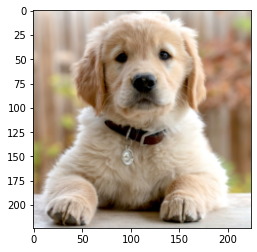

In [29]:
img = transform(img) 
plt.imshow(im_convert(img))

In [30]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dogs
